# Part 2: Repertoire richness and diversity calculations

For this section of the tutorials, the use of scikit-bio for repertoire diversity calculations will be illustrated. <br>
In addition, this notebook shows you how to calculate repertoire richness and overlap between different repertoires.

In [1]:
# Import packages

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd

from skbio.diversity.alpha import shannon, gini_index, pielou_e, simpson

In [2]:
# Load the data

# Define the current working directory
cwd = '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final'

# Read in the correct data files
P1_pre = pd.read_csv(f'{cwd}/Processed_data/P1_pre_data.tsv', sep='\t')
P1_post = pd.read_csv(f'{cwd}/Processed_data/P1_post_data.tsv', sep='\t')
Patient1_total = pd.read_csv(f'{cwd}/Processed_data/Patient1_total_data.tsv', sep='\t')

P2_pre = pd.read_csv(f'{cwd}/Processed_data/P2_pre_data.tsv', sep='\t')
P2_post = pd.read_csv(f'{cwd}/Processed_data/P2_post_data.tsv', sep='\t')
Patient2_total = pd.read_csv(f'{cwd}/Processed_data/Patient2_total_data.tsv', sep='\t')

P3_pre = pd.read_csv(f'{cwd}/Processed_data/P3_pre_data.tsv', sep='\t')
P3_post = pd.read_csv(f'{cwd}/Processed_data/P3_post_data.tsv', sep='\t')
Patient3_total = pd.read_csv(f'{cwd}/Processed_data/Patient3_total_data.tsv', sep='\t')

## Diversity calculations:
- Repertoire richness
- Shannon diversity
- Normalized Shannon diversity (Pielou's evenness)
- Simpson and Gini-Simpson diversity
- Gini coefficient
- DE50

In [3]:
# Define calculations for 50th percentile diversity

def get_50th_percentile(data):
    # Calculate clone frequency percentage based on clone counts
    Total = data['Total_frequency'].sum()
    data['Frequency'] = data.apply(lambda row: row.Total_frequency/Total, axis = 1)

    # Sort the data from high to low frequency
    data.sort_values(by='Frequency', ascending=False)

    # Calculate the cummulative frequency
    data['cumulative_sum'] = data['Frequency'].cumsum()

    # Identify the number of clones needed to reach the threshold value
    First_index = data[data.cumulative_sum >= 0.5].index[0]
    Ratio = First_index/len(data)
    return Ratio

In [4]:
# Calculate all diversity metrics and combine results in a single dataframe
Dataframes = [P1_pre, P1_post, P2_pre, P2_post, P3_pre, P3_post]
Patients = ['P1_pre', 'P1_post', 'P2_pre', 'P2_post', 'P3_pre', 'P3_post']
Df = []

for i, j in zip(Dataframes, Patients):
    Patient_id = j
    i = i.rename(columns={'Frequency_pre': 'Total_frequency', 'Frequency_post': 'Total_frequency'})
    Richness = len(i)
    Shannon = shannon(i['Total_frequency'], base=2)
    Pielou = pielou_e(i['Total_frequency'])
    Simpson = simpson(i['Total_frequency'])
    Gini = gini_index(i['Total_frequency'])
    DE50 = get_50th_percentile(i)
    df = pd.DataFrame({
        'Patient_id': [Patient_id],
        'Richness': [Richness],
        'Shannon_index': [Shannon],
        'Pielou_evenness': [Pielou],
        'Gini-Simpson': [Simpson],
        'Gini_index': [Gini],
        'DE50': [DE50]})
    Df.append(df)

Result_df = pd.concat(Df)
Result_df.reset_index(drop=True, inplace=True)
Result_df

,Patient_id,Richness,Shannon_index,Pielou_evenness,Gini-Simpson,Gini_index,DE50
0,P1_pre,15074,11.236565,0.809564,0.996644,0.715936,0.023418
1,P1_post,2720,7.902048,0.692592,0.936423,0.730809,0.013971
2,P2_pre,17976,10.256699,0.725687,0.987401,0.802038,0.007677
3,P2_post,39808,11.560222,0.756521,0.995896,0.817275,0.010902
4,P3_pre,11584,12.273467,0.909156,0.998595,0.466271,0.194838
5,P3_post,46629,11.076526,0.714203,0.995098,0.852803,0.004311


## Plot the diversity results

In [5]:
# Get visual plots depicting the diversity metrics using matplotlib

def get_metric_plots(dataframe, metric_index, title):

    # Set x-axis values and select data
    x = ['Pre-treatment', 'Post-treatment']
    Pat1_m = [dataframe.iloc[0,metric_index], dataframe.iloc[1,metric_index]]
    Pat2_m = [dataframe.iloc[2,metric_index], dataframe.iloc[3,metric_index]]
    Pat3_m = [dataframe.iloc[4,metric_index], dataframe.iloc[5,metric_index]]

    # Plot the figure
    plt.plot(x, Pat1_m, linestyle="-", marker="o", label="Patient 1")
    plt.plot(x, Pat2_m, linestyle="-", marker="o", label="Patient 2")
    plt.plot(x, Pat3_m, linestyle="-", marker="o", label="Patient 3")
    plt.title(f'{title} distibutions', fontsize=15)
    plt.ylabel(f'{title} score', fontsize=12)
    plt.legend()

    plt.savefig(f'{cwd}/Figures/{title}.jpg',bbox_inches='tight',dpi=400)

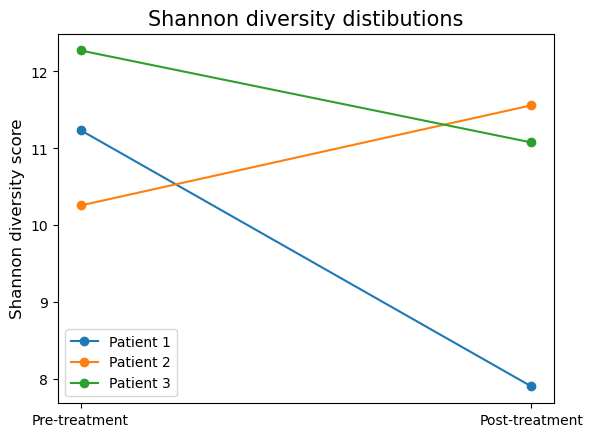

In [7]:
# Shannon diversity results

Shannon_plot = get_metric_plots(Result_df, 2, 'Shannon diversity')

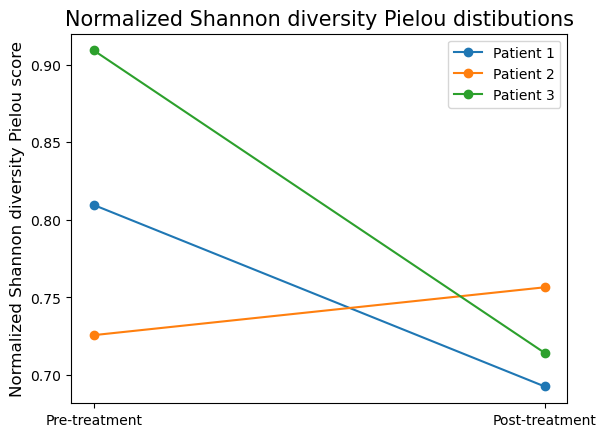

In [8]:
# Pielou diversity results

Pielou_plot = get_metric_plots(Result_df, 3, 'Normalized Shannon diversity Pielou')

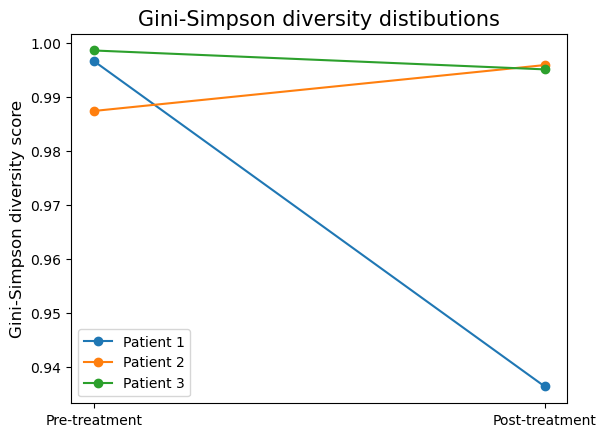

In [ ]:
# Gini-Simpson results

Gini_Simpson_plot = get_metric_plots(Result_df, 4, 'Gini-Simpson diversity')

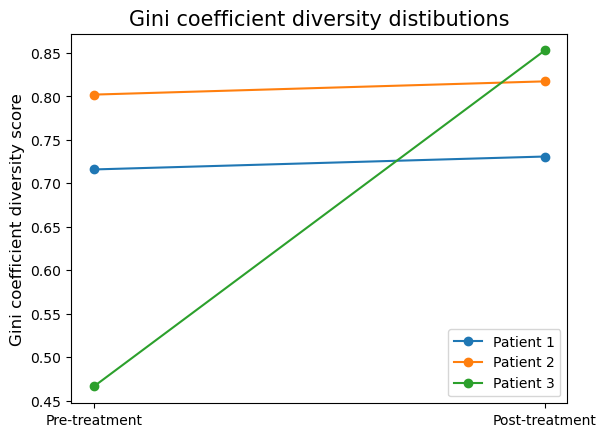

In [ ]:
# Gini coefficient results

Gini_coefficient_plot = get_metric_plots(Result_df, 5, 'Gini coefficient diversity')

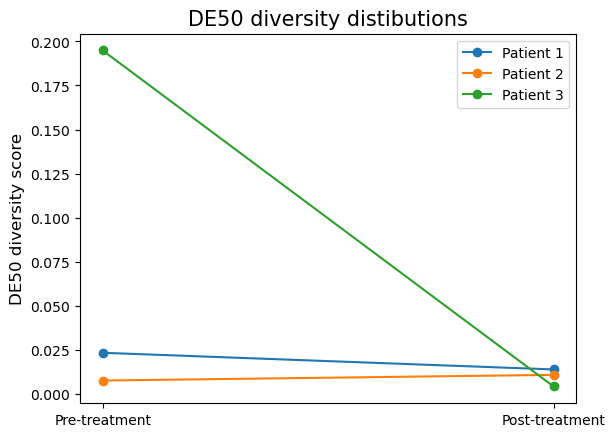

In [ ]:
# DE50 results

DE50_plot = get_metric_plots(Result_df, 6, 'DE50 diversity')

## Calculate repertoire overlap and public clones

In [19]:
# Define Jaccard and Morisita repertoire ovelap calculations

def get_repertoire_overlap(data_pre, data_post):
    overlap = data_pre.merge(data_post, how='inner', on=['Full_CDR3'])
    return len(overlap)


def get_jaccard_index(data_pre, data_post):

    # Get the number of overlapping clones based on the full CDR3 sequence
    Cij = len(data_pre.merge(data_post, how='inner', on=['Full_CDR3']))

    # Get the total number of unique clones in each repertoire
    Ni = len(data_pre)
    Nj = len(data_post)

    # Calculate Jaccard index
    Jaccard = (Cij)/(Ni+Nj-Cij)

    return Jaccard


def get_morisita_index(data1, data2):
    
    # Get the total clone counts in the repertoires 
    n1 = data1['Total_frequency'].sum()
    n2 = data2['Total_frequency'].sum()
    
    # Calculate clone count frequency of every TCR in the repertoires (i.e. N1i/N1 and N2i/N2)
    data1['Clone_frequency']=data1['Total_frequency']/n1
    data2['Clone_frequency']=data2['Total_frequency']/n2
    
    # Get public TCRs
    public = data1.merge(data2, how='inner', on=['Full_CDR3'], suffixes=['_1','_2'])
    
    # Calculate product of clone frequencies for every public TCR
    public['N1iN2i'] = public['Total_frequency_1']*public['Total_frequency_2']
    
    # Calculate morisita index
    numerator = 2*(public['N1iN2i'].sum())
    denominator = (public['Clone_frequency_1'].sum() + public['Clone_frequency_2'].sum())*n1*n2
    morisita_index = numerator/denominator
    
    return morisita_index


def get_public_clones(Patient1, Patient2, Patient3):

    # Set additional column indicating patient number
    Patient1['Patient'] = 'P1'
    Patient2['Patient'] = 'P2'
    Patient3['Patient'] = 'P3'

    # Concat all three dataframes
    all_tcrs = pd.concat([Patient1, Patient2, Patient3])

    # Determine public sequences between the different patients
    overlap = all_tcrs.groupby(['Full_CDR3'])['Patient'].apply(','.join).reset_index()
    Public = overlap[overlap['Patient'].str.contains(',')]
    print('The number of public TCRs is:', len(Public))
    
    return Public

In [20]:
# Calculate Jaccard and Morisita index per patient
Repertoires_pre = [P1_pre, P2_pre, P3_pre]
Repertoires_post = [P1_post, P2_post, P3_post]
Patient_names = ['Patient 1', 'Patient 2', 'Patient 3']

for a,b,c in zip (Repertoires_pre, Repertoires_post, Patient_names):
    # Get overlap size
    Overlap = get_repertoire_overlap(a,b)
    print('\nCalculating for', c, ':')
    print('The overlap between pre and post is', Overlap, 'TCRs')

    # Get Jaccard index
    Jaccard = get_jaccard_index(a,b)
    print('The Jaccard index is:', '{:.4f}'.format(Jaccard))

    # Get Morisita index
    Morisita = get_morisita_index(a,b)
    print('The Morisita index is:', '{:.4f}'.format(Morisita))


Calculating for Patient 1 :
The overlap between pre and post is 1566 TCRs
The Jaccard index is: 0.0965
The Morisita index is: 0.0016

Calculating for Patient 2 :
The overlap between pre and post is 8015 TCRs
The Jaccard index is: 0.1610
The Morisita index is: 0.0023

Calculating for Patient 3 :
The overlap between pre and post is 5308 TCRs
The Jaccard index is: 0.1003
The Morisita index is: 0.0027


In [21]:
# Jaccard metric between different post-treatment repertoires
Repertoires_pre = [P1_post, P1_post, P2_post]
Repertoires_post = [P2_post, P3_post, P3_post]
Comparison = ['Patient 1 - Patient 2', 'Patient 1 - Patient 3', 'Patient 2 - Patient 3']

for a,b,c in zip (Repertoires_pre, Repertoires_post, Comparison):
    # Get overlap size
    Overlap = get_repertoire_overlap(a,b)
    print('\nCalculating for', c, ':')
    print('The overlap is', Overlap, 'TCRs')

    # Get Jaccard index
    Jaccard = get_jaccard_index(a,b)
    print('The Jaccard index for is:', '{:.4f}'.format(Jaccard))

    # Get Morisita index
    Morisita = get_morisita_index(a,b)
    print('The Morisita index is:', '{:.4f}'.format(Morisita))



Calculating for Patient 1 - Patient 2 :
The overlap is 18 TCRs
The Jaccard index for is: 0.0004
The Morisita index is: 0.0000

Calculating for Patient 1 - Patient 3 :
The overlap is 18 TCRs
The Jaccard index for is: 0.0004
The Morisita index is: 0.0000

Calculating for Patient 2 - Patient 3 :
The overlap is 200 TCRs
The Jaccard index for is: 0.0023
The Morisita index is: 0.0000


In [22]:
# Determine public TCR sequences between the three full repertoires
print('Public TCRs in both pre and post TCR repertoires:')
Public_full = get_public_clones(Patient1_total, Patient2_total, Patient3_total)

Public TCRs in both pre and post TCR repertoires:
The number of public TCRs is: 484


In [23]:
# Show public TCR sequences and between which patients they are shared
Public_full

,Full_CDR3,Patient
1060,CAISAGDNQPQHF_TCRBV10_TCRBJ01,"P2,P3"
1668,CAISESGGAYEQYF_TCRBV10_TCRBJ02,"P1,P3"
4357,CASGGTVSYEQYF_TCRBV02_TCRBJ02,"P1,P2"
4669,CASGLQGGTEAFF_TCRBV12_TCRBJ01,"P1,P2"
8470,CASNRQGLGYTF_TCRBV06_TCRBJ01,"P1,P2"
...,...,...
116202,CSVEGDNYGYTF_TCRBV29_TCRBJ01,"P2,P3"
116846,CSVGGTDTQYF_TCRBV29_TCRBJ02,"P2,P3"
117075,CSVGTGYEQYF_TCRBV29_TCRBJ02,"P2,P3"
117553,CSVRDGSYEQYF_TCRBV29_TCRBJ02,"P2,P3"
